In [1]:
# Canny Edge Detection Implementation

# General
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import math
from PIL import Image

In [2]:
def getGaussian(sigma, length):
    # create a 1d gaussian mask with std deviation of sigma. 
    # G(x) = ( 1 / ( 2*pi*sigma^2 ) ) e^( ( -x^2+y^2 ) / (2*sigma^2))

    arr = np.linspace( -(length-1.0) / 2.0, (length-1.0) / 2.0, length)
    arr = np.exp(np.square(arr) / (-2 * np.square(sigma)))
    arr = arr * (1 / (sigma * np.sqrt(2 * np.pi)))

    G = arr / np.sum(arr) # sum of arr should add up to 1 
    
    return G

def convolution(image, mask, horozontal, verbose=False):
    
    if not horozontal: 
        image = np.rot90(image)
    
    image_row, image_col = image.shape
    
    # output Image dimension = starting dimensions
    # N = (N - F + 2P) / S + 1   (assume stride = 1)
    # P = (F - 1) / 2            (solving for P we get)
    padding = int((len(mask) - 1) / 2)

    # make a larger matrix to hold our padded image
    padded_image = np.zeros((image_row, image_col + (2 * padding))) 
    
    # insert original image
    padded_image[0:padded_image.shape[0], padding:padded_image.shape[1] - padding] = image
    
    I_convo = np.zeros((image_row, image_col))

    for i in range(image_row):
        for j in range(image_col):
            I_convo[i,j] = np.sum(padded_image[i, j:j+padding*2+1]*mask[:])
    
    if not horozontal: 
        I_convo = np.rot90(I_convo, k=3)
    
    if verbose:
        plt.imshow(I_convo,cmap='gray')
        plt.show()

    return I_convo

def combine(Ix, Iy, verbose=False):
    if Ix.shape != Iy.shape:
        print('sizes don\'t match')
        return
    image_row,image_col = Ix.shape
    M = np.zeros((image_row, image_col))

    M = np.sqrt(np.square(Ix) + np.square(Iy))
    
    if verbose:
        plt.imshow(M,cmap='gray')
        plt.show()
        
    return M

def non_max_suppression(M, angle, verbose = False):
    M_row, M_col = M.shape
    ret = np.zeros((M_row, M_col))
    
    # Convert radians (-pi,pi) to degrees (0, 180)
    angle = angle * 180. / np.pi
    angle[angle < 0] += 180
    
    for i in range(1, M_row-1):
        for j in range(1, M_col-1):
            # Gradient is left and right -> check up and down
            if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                a = M[i+1, j]
                b = M[i-1, j]
            # Graident is top-right and bottom-left -> check top-left and bottom-right
            if (22.5 <= angle[i,j] < 67.5):
                a = M[i-1, j-1]
                b = M[i+1, j+1]
            # Gradient is top and bottom -> check right and left
            if (67.5 <= angle[i,j] < 112.5):
                a = M[i, j+1]
                b = M[i, j-1]
            # Gradient is top-left and bottom-right -> check top-right and bottom-right
            if (112.5 <= angle[i,j] < 157.5):
                a = M[i+1, j-1]
                b = M[i-1, j+1]
            
            # If (i,j) is not a maximum it needs to be suppressed
            if (M[i,j] > a) and (M[i,j] > b):
                ret[i,j] = M[i,j]
            else:
                ret[i,j] = 0
    if verbose:
        plt.imshow(ret,cmap='gray')
        plt.show()

    return ret

def hysteresis_thresholding(NMS, high = 25, low = 14, verbose = False):
    NMS_rows, NMS_cols = NMS.shape
    
    # Set all unvisited positions to -1
    # Edges -> 1
    # Non-Edges -> 0
    HT = np.zeros((NMS_rows, NMS_cols)) - 1
    
    # BFS
    for i in range(0, NMS_rows):
        for j in range(0, NMS_cols):

            # Skip already visited nodes
            if HT[i,j] != -1:
                continue
            
            # Not an edge
            if NMS[i,j] < high:
                HT[i,j] = 0
            
            # If we hit a value >= high, BFS for all other pixels that are greater than low
            if NMS[i,j] >= high:
                
                # Create a queue for BFS
                queue = []

                # Enqueue source pixel location
                queue.append([i,j])

                while queue:
                    
                    # Dequeue a pixel from queue and make it our new coordinate
                    s = queue.pop(0)
                    r = s[0]
                    c = s[1]
                    
                    # Already Visited
                    if HT[r,c] != -1:
                        continue
                    
                    # Mark coordinate as edge
                    HT[r,c] = 1
                    
                    dx = [-1,-1, 0, 1, 1, 1, 0,-1]
                    dy = [ 0, 1, 1, 1, 0,-1,-1,-1]
                    #dx = [-1, 0, 1, 0]
                    #dy = [ 0, 1, 0,-1]
                    
                    # Get all adjacent pixels of the current pixel
                    for k in range(len(dx)):
                        # Get new row and col
                        nR = r+dy[k]
                        nC = c+dx[k]
                        
                        # Skip if out of bounds or already visited
                        if nR < 0 or nR >= NMS_rows or nC < 0 or nC >= NMS_cols or HT[nR,nC] != -1:
                            continue
                        
                        # If adjacent pixel is above low threshold it is also an adge
                        if NMS[nR,nC] > low:
                            queue.append([nR,nC])
                      
    # Set all edges to white
    HT *= 255
    
    if verbose:
        plt.imshow(HT,cmap='gray')
        plt.show()
        
    return HT

In [3]:
def edge_detection(file_path, sigma = 1, thresh_H=50, thresh_l=30, verbose = False,final_output=True):
    
    # Step 1: Read in input
    I = img.imread(file_path)
    if verbose:
        Image.open(file_path)

    # Step 2: Getting our gaussian filter
    G = getGaussian(sigma = sigma, length = 7)

    # Step 3: One-dimensional mask for the first derivative
    Gx = [-1, 0, 1]
    Gy = [-1, 0, 1]

    # Step 4: Applying horozontal and vertical gaussian filters
    Ix = convolution(I, G, horozontal=True, verbose=verbose)
    Iy = convolution(I, G, horozontal=False, verbose=verbose)


    # Step 5: Find dirivatives in horozontal and vertical directions
    dIx = convolution(np.absolute(Ix), Gx, horozontal=True, verbose=verbose)
    dIy = convolution(np.absolute(Iy), Gy, horozontal=False, verbose=verbose)
    
    #Step 6: Compute the magnitude of the edge response
    M = combine(dIx, dIy, verbose = verbose)

    # Step 7: Implement non-maximum suppression
    angle = np.arctan2(np.absolute(Ix),np.absolute(Iy))
    NMS = non_max_suppression(M, angle, verbose = verbose)

    # Step 8: Apply Hysteresis thresholding
    HT = hysteresis_thresholding(NMS, high = thresh_H, low = thresh_l, verbose = verbose)
    
    if not final_output:
        # Display results and Intermediate steps
        fig, axis = plt.subplots(2, 3,figsize=(25,15))
        # Turn off x/y axis
        [axi.set_axis_off() for axi in axis.ravel()]

        axis[0,0].imshow(Ix,cmap='gray', vmin=0, vmax=255.)
        axis[0,0].set_title('Horozontal Gaussian')

        axis[0,1].imshow(Iy,cmap='gray', vmin=0, vmax=255.)
        axis[0,1].set_title('Vertial Gaussian')
    
        axis[0,2].imshow(dIx,cmap='gray', vmin=-255., vmax=255.)
        axis[0,2].set_title('Horozontal Derivative')

        axis[1,0].imshow(dIy,cmap='gray', vmin=-255., vmax=255.)
        axis[1,0].set_title('Vertical Derivative')

        axis[1,1].imshow(M*2,cmap='gray', vmin=0, vmax=255.)
        axis[1,1].set_title('Edge Response Magnitude')

        axis[1,2].imshow(HT,cmap='gray', vmin=0, vmax=255.)
        axis[1,2].set_title('Final Edge-Map')

        plt.show()
    else: 
        plt.imshow(HT,cmap='gray')
        plt.axis(False)
        plt.show()

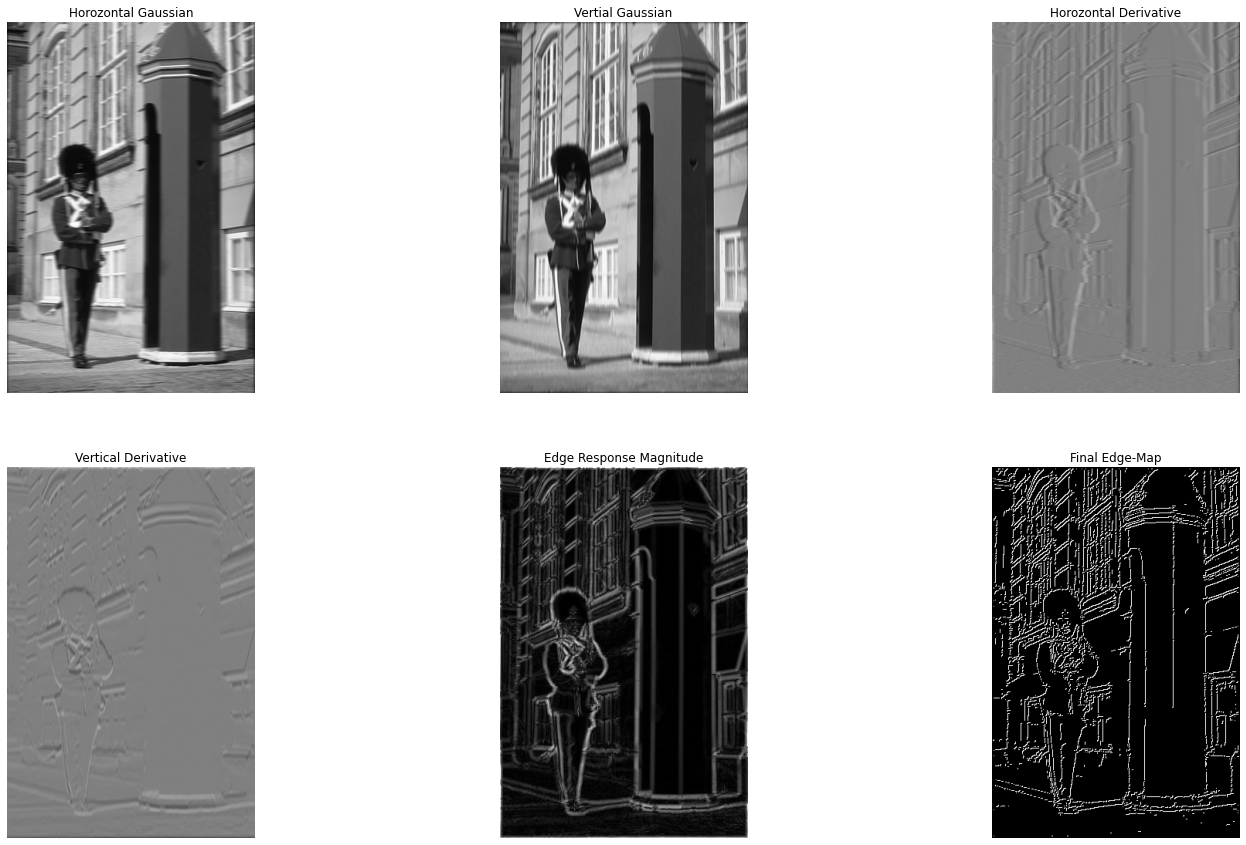

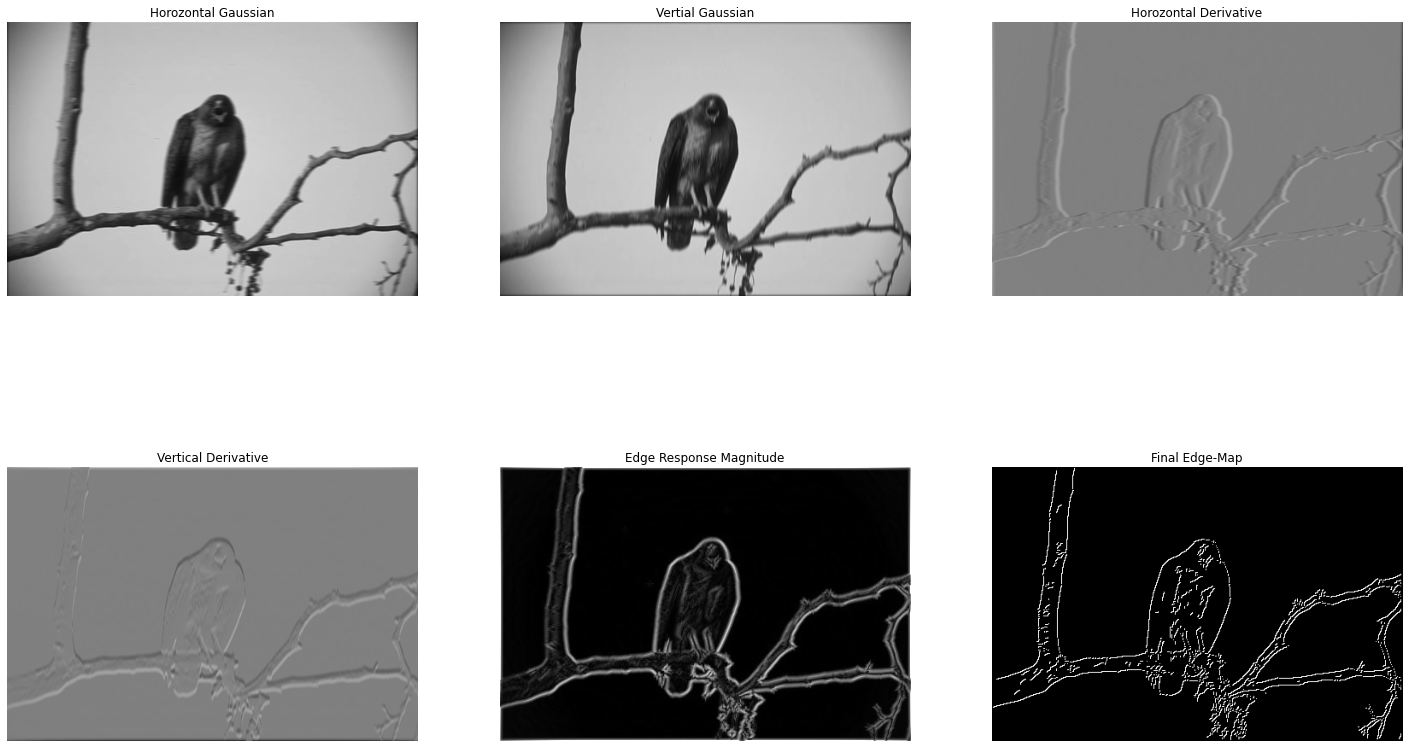

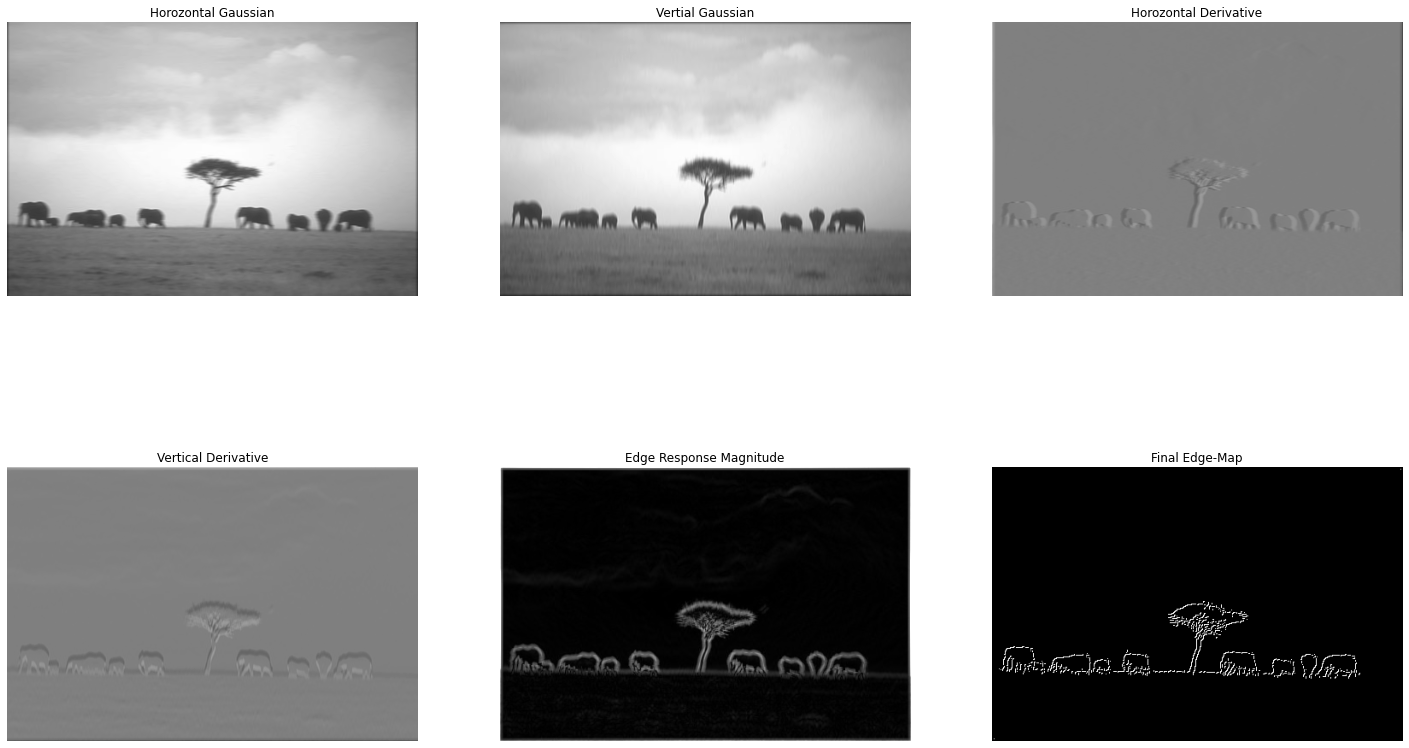

In [4]:
file_paths = ['./Data/bird.jpg','./Data/queen_guard.jpg' , './Data/elephants_field.jpg']
sigma = [2, 2.5, 2.8]
for i in range(len(file_paths)):
    edge_detection(file_paths[i], 
                   sigma = sigma[i], 
                   thresh_H=21, 
                   thresh_l=14, 
                   verbose=False, 
                   final_output=False)